## Naive Preliminary Model for HAM10000

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from PIL import Image
import warnings 
import numpy as np
warnings.filterwarnings('ignore') 

import torchvision
from torchvision import transforms
import torch.utils.data as data

In [2]:
df = df2 = pd.read_csv('HAM 10000/HAM10000_metadata.csv')
df = df.dropna()
df = df[df['sex'] != 'unknown']
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Importing images into dataframe
for convenience, add 2 new columns to df (image path and image)

In [3]:
# get all image paths
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('HAM 10000/', '*', '*.jpg'))}
# Define the path and add as a new column
df['path'] = df['image_id'].map(image_path.get)
#Use the path to read images.
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

print(df['dx'].value_counts())

dx
nv       6650
mel      1111
bkl      1089
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


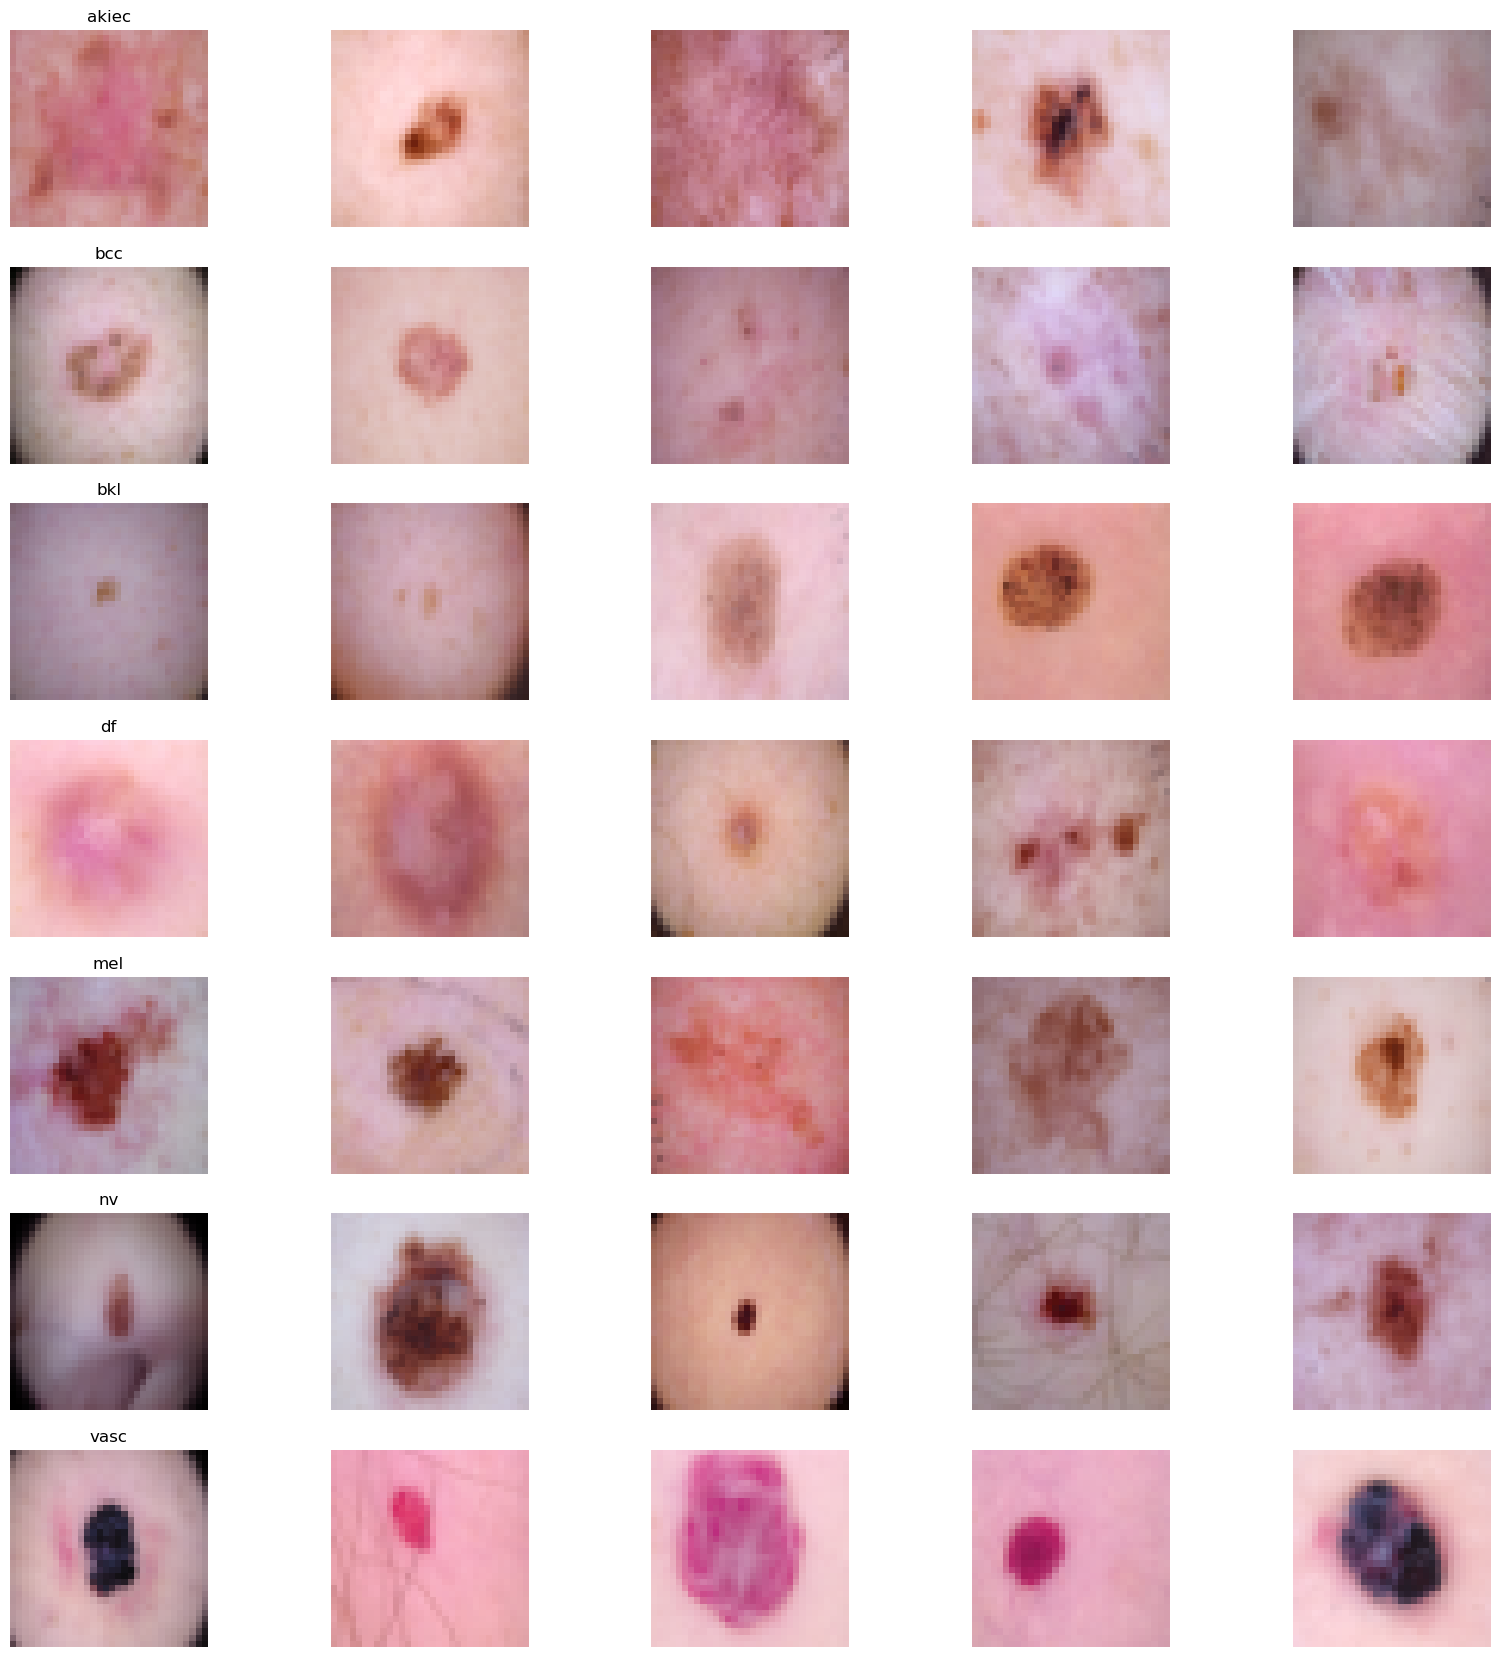

In [4]:
n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [5]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM 10000/HAM10000_images_part_1/ISIC_0027419.jpg,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM 10000/HAM10000_images_part_1/ISIC_0025030.jpg,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM 10000/HAM10000_images_part_1/ISIC_0026769.jpg,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM 10000/HAM10000_images_part_1/ISIC_0025661.jpg,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM 10000/HAM10000_images_part_2/ISIC_0031633.jpg,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."


### Logistic Regression

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Prepare the data
X = np.array(df['image'].tolist())
y = df['dx']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the image arrays
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_flat, y_train)

# Evaluate the model
y_pred = model.predict(X_test_flat)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

       akiec       0.18      0.15      0.16        60
         bcc       0.36      0.30      0.33        97
         bkl       0.37      0.27      0.31       224
          df       0.00      0.00      0.00        29
         mel       0.33      0.18      0.23       223
          nv       0.78      0.90      0.84      1336
        vasc       0.35      0.38      0.36        21

    accuracy                           0.68      1990
   macro avg       0.34      0.31      0.32      1990
weighted avg       0.63      0.68      0.65      1990

[[   9    7   16    1    4   22    1]
 [  13   29   12    2    4   33    4]
 [   6   15   61    2   22  118    0]
 [   5    5    3    0    1   15    0]
 [   7    9   29    2   40  135    1]
 [  11   11   45    3   49 1208    9]
 [   0    4    1    0    0    8    8]]


### Using CNN

#### Architecture used:
- 3 Convolutional layers each followed by ReLU activation function, max-pooling layer after each conv to reduce spatial dimensions
- 2 Fully connected layers; flatten output of last conv layer

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*4*4, 512)  # Adjusted input size for fully connected layer
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# Preprocessing and data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
])


class SkinCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.data['encoded_label'] = self.label_encoder.fit_transform(self.data['dx'])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data.iloc[idx]['path'])
        label = self.data.iloc[idx]['encoded_label']
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label)


# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define datasets and dataloaders
train_dataset = SkinCancerDataset(train_df, transform=transform)
test_dataset = SkinCancerDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the model
num_classes = len(df['dx'].unique()) # Number of classes
model = CNN(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # print(type(images), type(labels))  # Print the type of images and labels
        images, labels = images.to(device), labels.to(device)  # Move each tensor to the device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {(correct / total) * 100:.2f}%')


Epoch [1/10], Loss: 1.0564
Epoch [2/10], Loss: 0.9035
Epoch [3/10], Loss: 0.8496
Epoch [4/10], Loss: 0.8091
Epoch [5/10], Loss: 0.7669
Epoch [6/10], Loss: 0.7332
Epoch [7/10], Loss: 0.7108
Epoch [8/10], Loss: 0.6946
Epoch [9/10], Loss: 0.6743
Epoch [10/10], Loss: 0.6522
Accuracy on test set: 74.77%


In [8]:
# Continue with more epochs
# Training the model
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        # print(type(images), type(labels))  # Print the type of images and labels
        images, labels = images.to(device), labels.to(device)  # Move each tensor to the device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {(correct / total) * 100:.2f}%')

Epoch [1/10], Loss: 0.6439
Epoch [2/10], Loss: 0.6322
Epoch [3/10], Loss: 0.6151
Epoch [4/10], Loss: 0.6047
Epoch [5/10], Loss: 0.5928
Epoch [6/10], Loss: 0.5895
Epoch [7/10], Loss: 0.5728
Epoch [8/10], Loss: 0.5553
Epoch [9/10], Loss: 0.5418
Epoch [10/10], Loss: 0.5257
Accuracy on test set: 74.97%


Since accuracy doesn't improve, need to take next steps to improve model

### Visualising model performance (CNN)

In [11]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, roc_auc_score

In [29]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# Convert tensors to numpy arrays
y_true = test_df['encoded_label'].values
y_pred = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

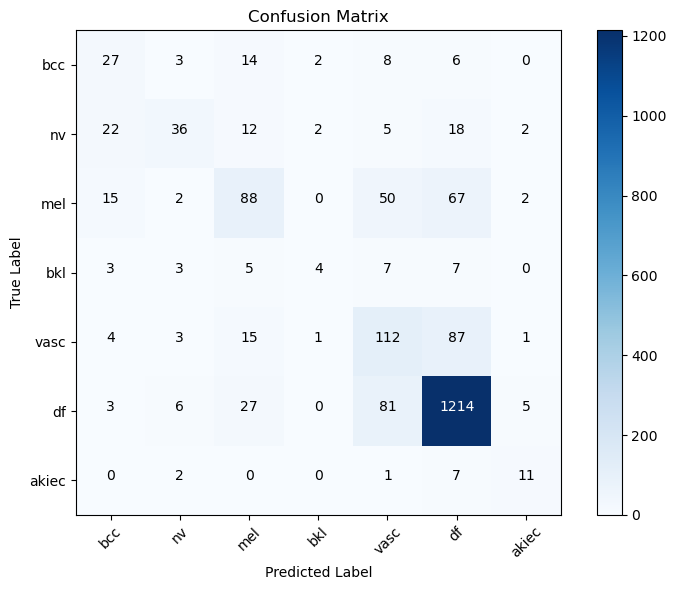

In [30]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, classes=test_df['dx'].unique())

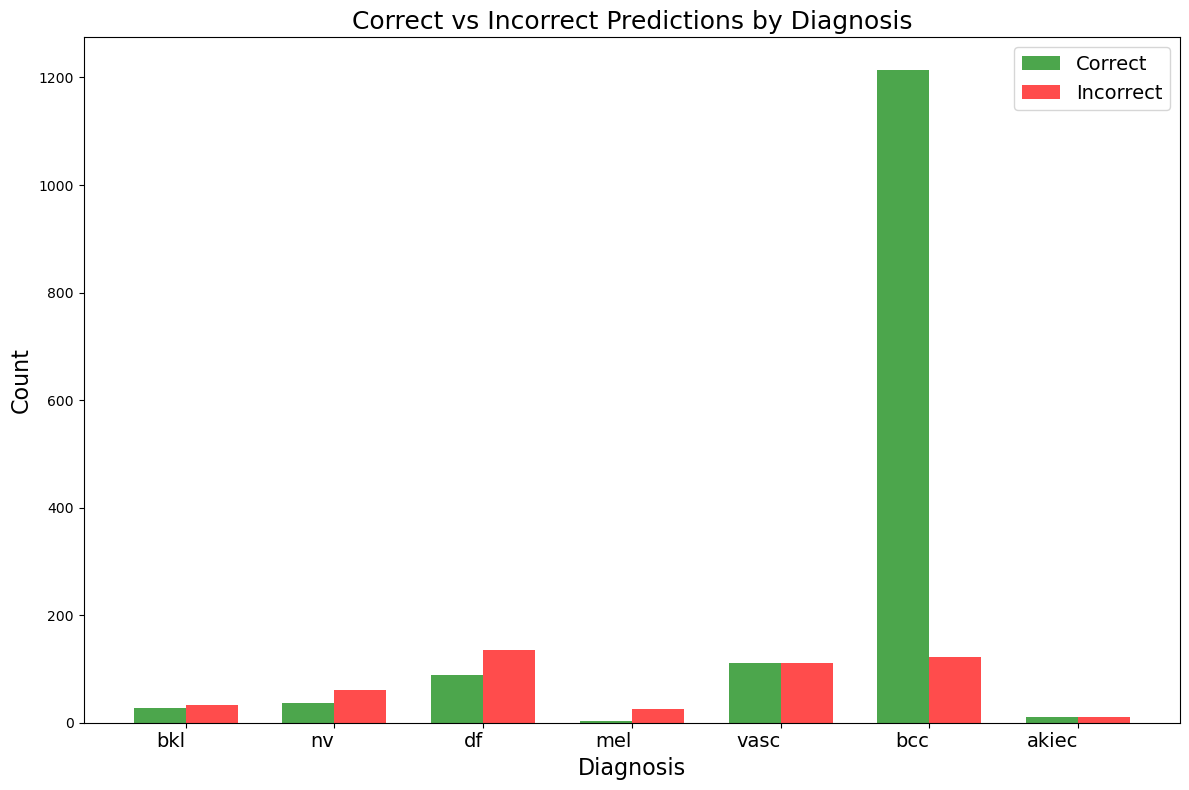

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame containing the dataset
diagnosis_names = df['dx'].unique()

# Convert predictions and true labels to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Identify correct and incorrect predictions
correct_indices = np.where(y_pred == y_true)[0]
incorrect_indices = np.where(y_pred != y_true)[0]

# Count the number of correctly and incorrectly classified points for each class
num_classes = len(diagnosis_names)
correct_counts = np.bincount(y_true[correct_indices], minlength=num_classes)
incorrect_counts = np.bincount(y_true[incorrect_indices], minlength=num_classes)

# Plot bar plot
x = np.arange(num_classes)
width = 0.35
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x - width/2, correct_counts, width, label='Correct', color='green', alpha=0.7)
ax.bar(x + width/2, incorrect_counts, width, label='Incorrect', color='red', alpha=0.7)
ax.set_xlabel('Diagnosis',fontsize=16)
ax.set_ylabel('Count',fontsize=16)
ax.set_title('Correct vs Incorrect Predictions by Diagnosis',fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(diagnosis_names, ha='right', fontsize=14)  # Rotate labels for better visibility
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()